# Importing Data

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import mode
import re

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
root = Path("data")
train_data = root/"train.csv"
test_data = root/"test.csv"

In [3]:
train = pd.read_csv(train_data)
test = pd.read_csv(test_data)

# Exporatory Data Analysis

In [4]:
# TODO: Detect outliers using turkey method

In [38]:
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [6]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# fill empty values for test set survived attribute
dataset.loc[dataset["Survived"].isnull(), "Survived"] = 0

In [41]:
dataset["Survived"] = dataset["Survived"].astype(int)

## Feature Analysis

In [44]:
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
Survived          0
PassengerId       0
dtype: int64

### Numerical Values

Let's first a heatmap to identify corellations with the Survived attribute.

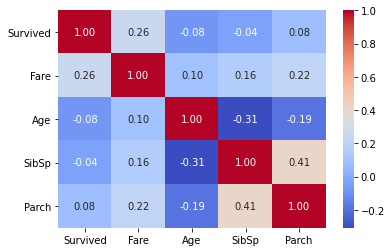

In [42]:
sns.heatmap(train[["Survived", "Fare", "Age", "SibSp", "Parch"]].corr(), annot=True, fmt=".2f", cmap="coolwarm");

Fare has a significant correllation with Survived, while Pclass has a negative correllation.

Let's check subpopulations of other features in order to identify their chance of survival.

#### Age

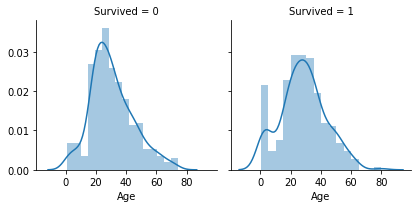

In [24]:
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

Age distribution is not the same in survived ant non survived population. That's evident since babies were more likely to survive.

Let's try to get a clearer picture of the age distribution.

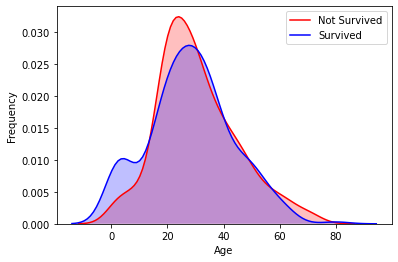

In [25]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

Ok so now we can clearly see that there's a peak for surviving younger ages.

#### SibSp

Let's see the correlation between survivability and the number of siblings on board.

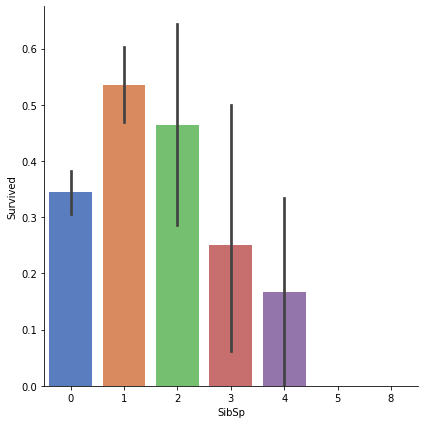

In [28]:
sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted");

Ok so people with less siblings/spouses on board have less chance to survive.

Maybe we can consider creating a new feature for that.

#### Parch

This feature describes the number of parents a children a person has onboard.

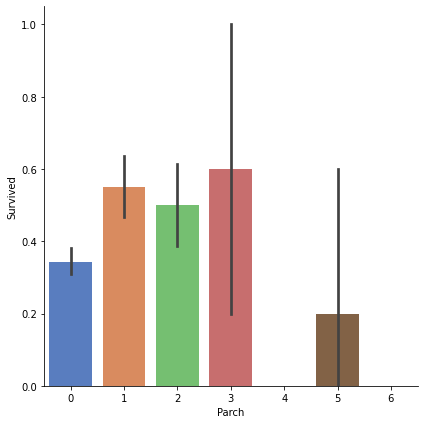

In [29]:
sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted");

Again, people with less parents/children have a higher chance to survive. We should be careful of the standard deviation on 3 and 5.

#### Fare

In [43]:
dataset["Fare"].isnull().sum()

1

Since only one Fare is missing fill it with the median value of the column

In [45]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Plot distribution.

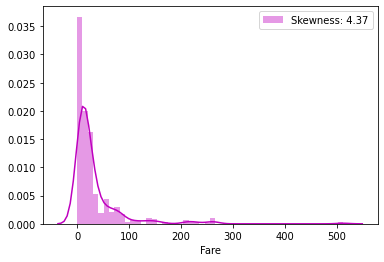

In [50]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness: %.2f" % dataset["Fare"].skew())
g = g.legend(loc="best")

The distribution is very skewed. This can lead to overweighting very high values in the model even if it is scaled.

We transform it with the log function to reduce the skew.

In [51]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

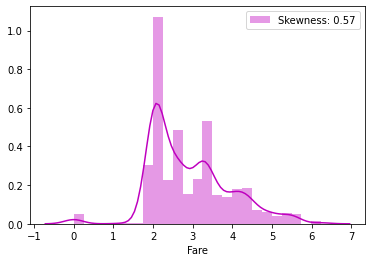

In [52]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness: %.2f" % dataset["Fare"].skew())
g = g.legend(loc="best")

Ok now the data is not as much skewed.

### Categorical Features

In [53]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S


#### Sex

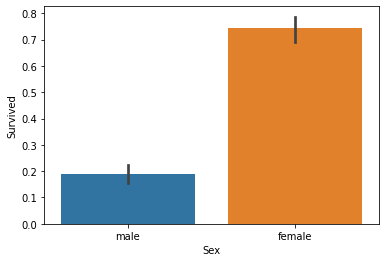

In [54]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_label("Survival Probability")

Ok now we see that females have a much higher survival rate.

#### Pclass

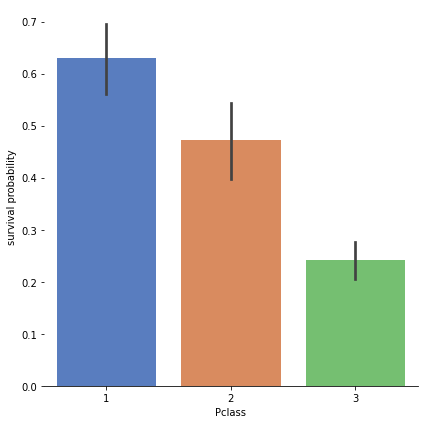

In [59]:
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It is clear that people in the first class have a higher chance of surviving.

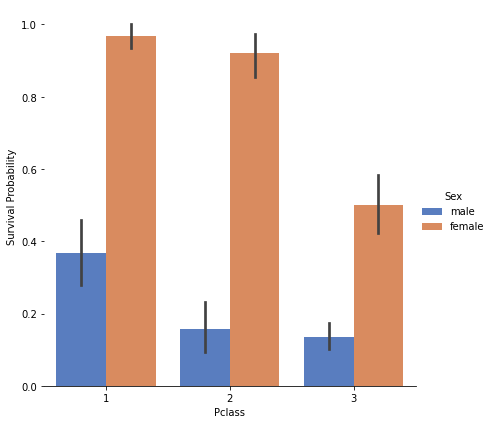

In [60]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

Ok so the results can be correllated with the Sex.

#### Embarked

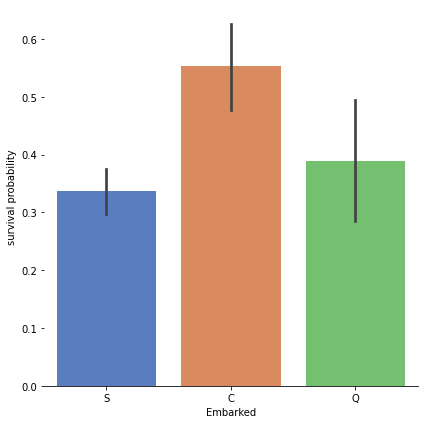

In [61]:
g = sns.factorplot(x="Embarked", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Passengers embarking from C have a higher chance of surviving.

Hypothesis: More first class passengers coming from C

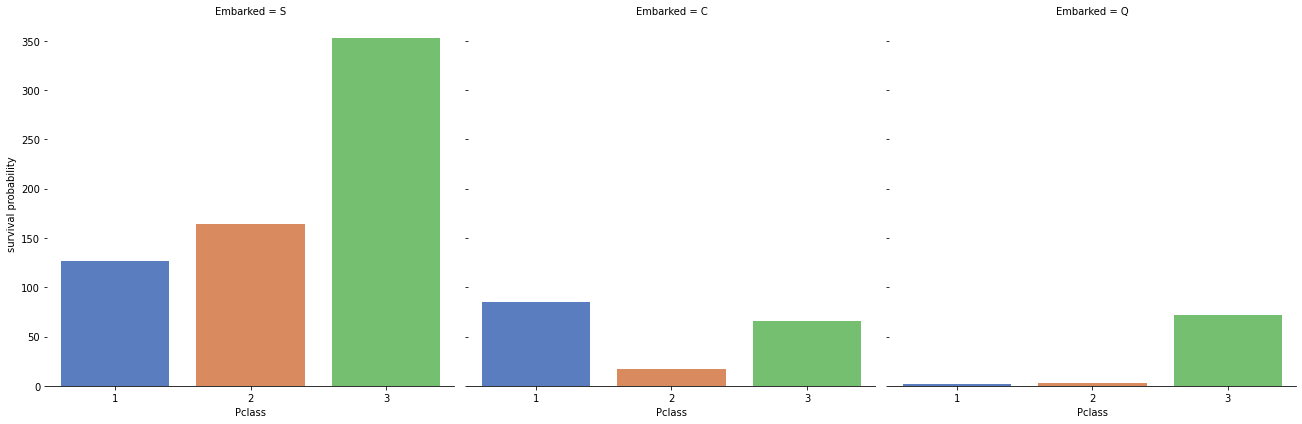

In [66]:
g = sns.factorplot("Pclass", col="Embarked", data=train, kind="count", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Indeed C served mostly first class passengers.

## Filling Missing Values

In [67]:
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Age             263
Embarked          2
Fare              0
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
Survived          0
PassengerId       0
dtype: int64

### Embarked

Let's fill missing values with the mode of the column.

In [70]:
dataset["Embarked"] = dataset["Embarked"].fillna(mode(dataset["Embarked"]))

### Age

Since there are subpopulations that are more likely to survive given their age, we will keep this feature and impute missing values.

In [71]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

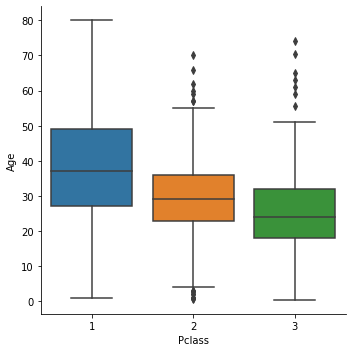

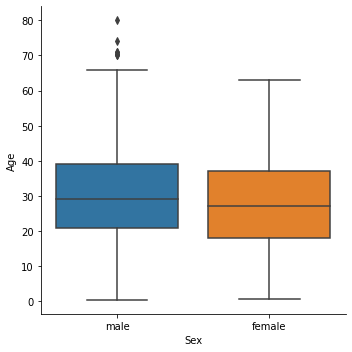

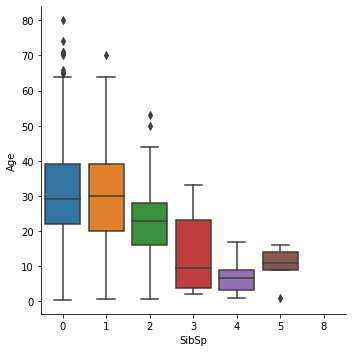

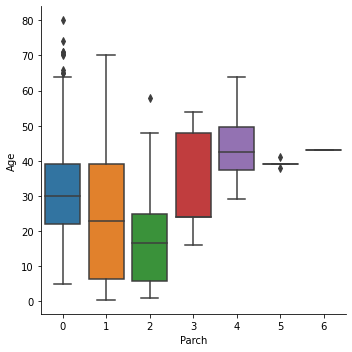

In [79]:
sns.factorplot(x="Pclass", y="Age", data=train, kind="box")
sns.factorplot(x="Sex", y="Age", data=train, kind="box")
sns.factorplot(x="SibSp", y="Age", data=train, kind="box")
sns.factorplot(x="Parch", y="Age", data=train, kind="box")

Sex doesn't seem to play an important role in determining the age of someone.

However, first class passengers are older than second class and second class than third class.

Also, people with a smaller number of siblings and spouses are older.

Also people with a small number of parents/children seem to be younger.

Let's also plot a correllation matrix.

First convert sexes to a numerical value.

In [80]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

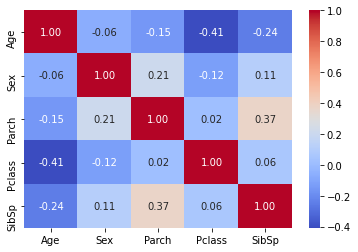

In [81]:
sns.heatmap(dataset[["Age", "Sex", "Parch", "Pclass", "SibSp"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

This further proves that age is correllated with SibSp, Pclass, Parch and not with Sex.

Let's impute missing values with columns which have similar values for those attributes.

In [91]:
index_none = dataset[dataset["Age"].isnull()].index

for idx in list(index_none):
    ssp = dataset.iloc[idx]["SibSp"]
    pcl = dataset.iloc[idx]["Pclass"]
    par = dataset.iloc[idx]["Parch"]
    med = dataset["Age"].median()
    
    val = dataset["Age"][(dataset["SibSp"] == ssp) & (dataset["Pclass"] == pcl) & (dataset["Parch"] == par)].median()
    if not np.isnan(val):
        dataset.loc[idx, "Age"] = val
    else:
        dataset.loc[idx, "Age"] = med

### Cabin

Fill missing cabin values with X

In [93]:
dataset["Cabin"] = dataset["Cabin"].fillna("X")

# Feature Engineering

## Name/Title

In [98]:
len(dataset["Name"].unique()), len(dataset)

(1307, 1309)

This is not good, let's replace all names with the titles of the passengers.

In [101]:
dataset["Title"] = dataset["Name"].str.extract(" ([a-zA-Z]+)\.", expand=False)

In [102]:
dataset["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

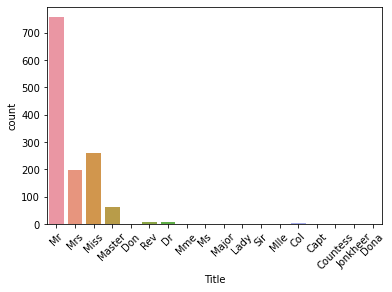

In [109]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

Ok so most titles are not used, so we'll replace them with Rare.

In [110]:
dataset["Title"] = dataset["Title"].replace(["Master", "Don", "Rev", "Dr", "Mme", "Ms", "Major", "Lady", "Sir", "Mlle", "Col", "Capt", "Countess", "Jonkheer", "Dona"], "Rare")

In [111]:
dataset["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Rare'], dtype=object)

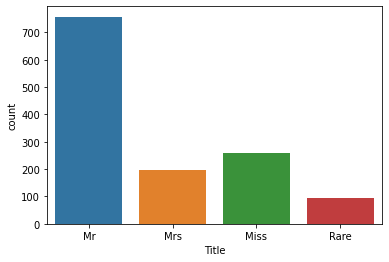

In [112]:
g = sns.countplot(dataset["Title"])

Convert to numerical categorical values.

In [113]:
dataset["Title"] = dataset["Title"].map({"Mr": 0, "Mrs": 1, "Miss": 1, "Rare": 2})

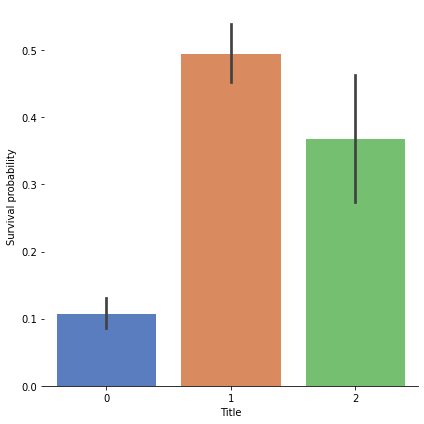

In [116]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

Women and children first.

## Family Size

Both SibSp and Parch describe the size of the family so let's join these features.

In [117]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"]

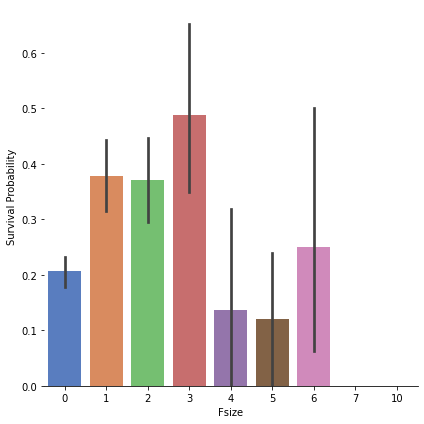

In [118]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

Smaller familys have a higher chance of surviving.

Let's create more features for family size.

In [124]:
dataset["Single"] = dataset["Fsize"].map(lambda x: 1 if x == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda x: 1 if x == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda x: 1 if 3 <= x <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda x: 1 if x >= 5 else 0)

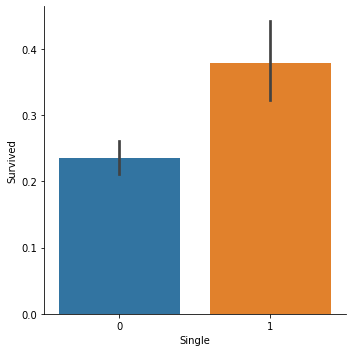

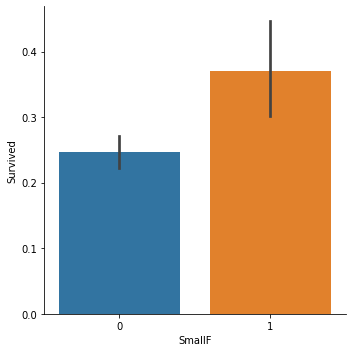

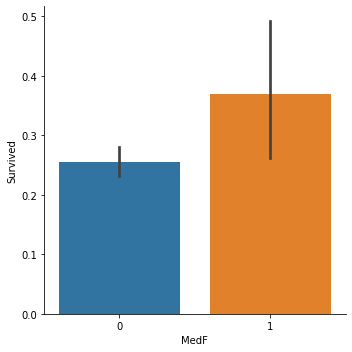

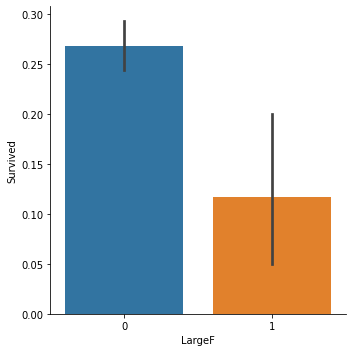

In [125]:
sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")

The factorplots show that Small and Medium families have a higher chance of survivng.

## Dummies

In [128]:
dataset = pd.get_dummies(dataset, columns=["Title"])

In [129]:
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [131]:
dataset.shape

(1309, 22)

We currently have 22 features.

## Cabin

In [132]:
dataset["Cabin"].head()

0       X
1     C85
2       X
3    C123
4       X
Name: Cabin, dtype: object

Let's extract the first letters of cabins.

In [134]:
dataset["Cabin"] = dataset["Cabin"].str.extract("([a-zA-Z])", expand=False)

In [135]:
dataset["Cabin"].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

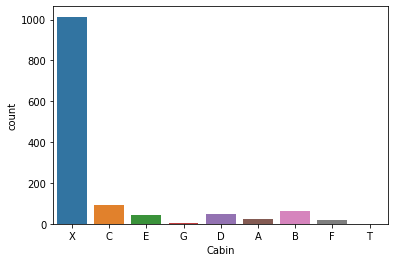

In [137]:
sns.countplot(x="Cabin", data=dataset)

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


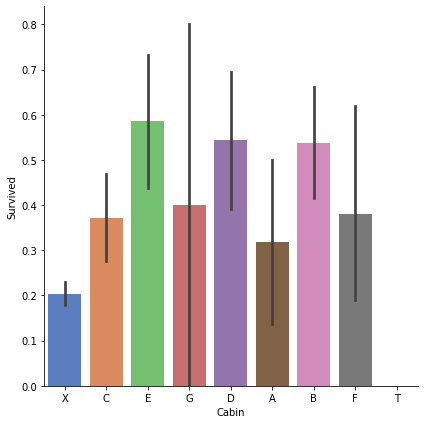

In [136]:
sns.factorplot(x="Cabin", y="Survived", data=dataset, kind="bar", size=6, palette="muted")

Even though people with cabins are more, they have a larger chance of surviving.

We see that different cabins have different survival rates so we'll keep dummy values for those.

In [138]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Ca")

In [139]:
dataset.shape

(1309, 30)

## Ticket

In [140]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [146]:
ticket = []

for t in list(dataset.Ticket):
    if not t.isdigit():
        ticket.append(t.replace(".", "").replace("/", "").strip().split(" ")[0])
    else:
        ticket.append("X")
dataset["Ticket"] = ticket

In [149]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [150]:
dataset.shape

(1309, 66)

We now have 66 features.

## Categorical values to dummies

In [152]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="P")

In [153]:
dataset.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,P_1,P_2,P_3
0,1,0,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,1,1,...,0,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,1,1,...,0,0,0,0,0,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,1,1,...,0,0,0,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,0,0,...,0,0,0,0,0,0,1,0,0,1


In [155]:
dataset.drop(["PassengerId"], axis=1, inplace=True)

In [182]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [156]:
dataset.shape

(1309, 67)

We have 67 features.

# Modeling

In [183]:
train_len = len(train)
train = dataset[:train_len]
test = dataset[train_len:]

In [184]:
test.drop(labels=["Survived"], axis=1, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [185]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

## Simple Modeling

We will compare 10 popular classifiers and evaluate the mean accuracy of each one of them by a statified kfold cross validation procedure.

In [187]:
kfold = StratifiedKFold(n_splits=10)
random_state = 42

classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis()
]

cv_means = []
cv_std = []

for cl in classifiers:
    score = cross_val_score(cl, X, y=y, scoring="accuracy", cv=kfold, n_jobs=4)
    cv_means.append(score.mean())
    cv_std.append(score.std())

cv_scores = pd.DataFrame({"CrossValMeans": cv_means, "CrossValErrors": cv_std, "Algorithm": [
    "SVC", "Decision Tree", "AdaBoost", "Random Forest", "ExtraTrees", "Gradient Boosting", "MLP", "KNN", "Logistic Regression", "Linear Discriminant"
]})

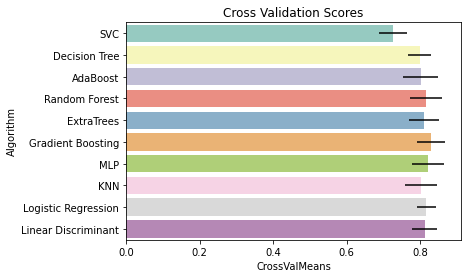

In [190]:
g = sns.barplot("CrossValMeans", "Algorithm", data=cv_scores, palette="Set3", orient="h", **{'xerr': cv_std})
g.set_label("Mean Accuracy")
g = g.set_title("Cross Validation Scores")

We will choose AdaBoost, GradientBoosting, RandomForest, ExtraTrees and MLP for further modelling.

## Hyperparameter Tuning for Best Models

We will perform grid search optimization to find the best parameters for the models.

In [192]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=42)

ada_param_grid = {
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__splitter": ["best", "random"],
    "algorithm": ["SAMME", "SAMME.R"],
    "n_estimators": [1,2],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X, y)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    4.3s finished


In [193]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X, y)

ex_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   48.6s finished


In [194]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X, y)

rf_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   52.4s finished


In [195]:
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1)

gsGBC.fit(X, y)

gbc_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   28.1s finished


In [196]:
SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1)

gsSVMC.fit(X, y)

svmc_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   23.8s finished


In [197]:
gsadaDTC.best_score_, gsExtC.best_score_, gsRFC.best_score_, gsGBC.best_score_, gsSVMC.best_score_

(0.8193508114856429,
 0.8272284644194757,
 0.832796504369538,
 0.8249438202247191,
 0.8350187265917602)

## Plot learning curves

Plotting the learning curves is a very good way to see if we're overfitting the dataset. So, we will plot the learning curves for all the above algorithms.

In [207]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of test and train learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                    alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                    alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Test score')
    
    plt.legend(loc="best")
    return plt

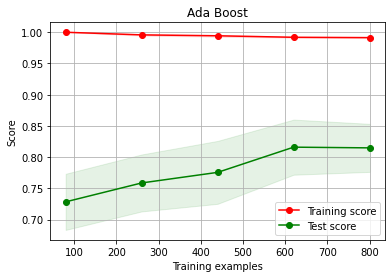

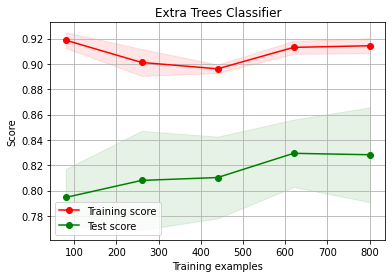

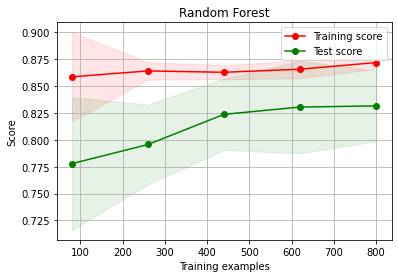

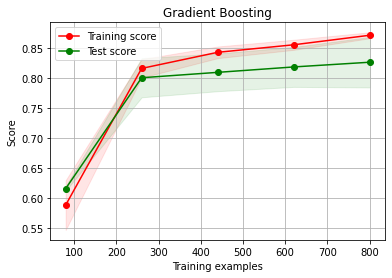

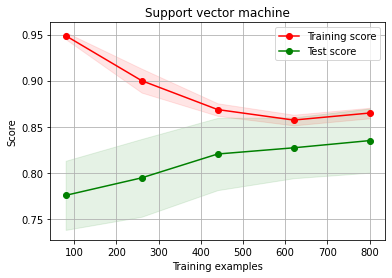

In [208]:
g = plot_learning_curve(gsadaDTC.best_estimator_, "Ada Boost", X, y, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "Extra Trees Classifier", X, y, cv=kfold)
g = plot_learning_curve(gsRFC.best_estimator_, "Random Forest", X, y, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "Gradient Boosting", X, y, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "Support vector machine", X, y, cv=kfold)

ADABoost and ExtraTrees seem to be overfitting the dataset. On the other hand RandomForest, GradientBoosting and SVN seem to produce good results.

According to their validation curves growth they could perform better with more examples.

## Feature Importance of Tree Based Classifiers

In order to see the most informative features for the prediction of a passenger's survival we display the feature importance for the 4 tree based classifiers.

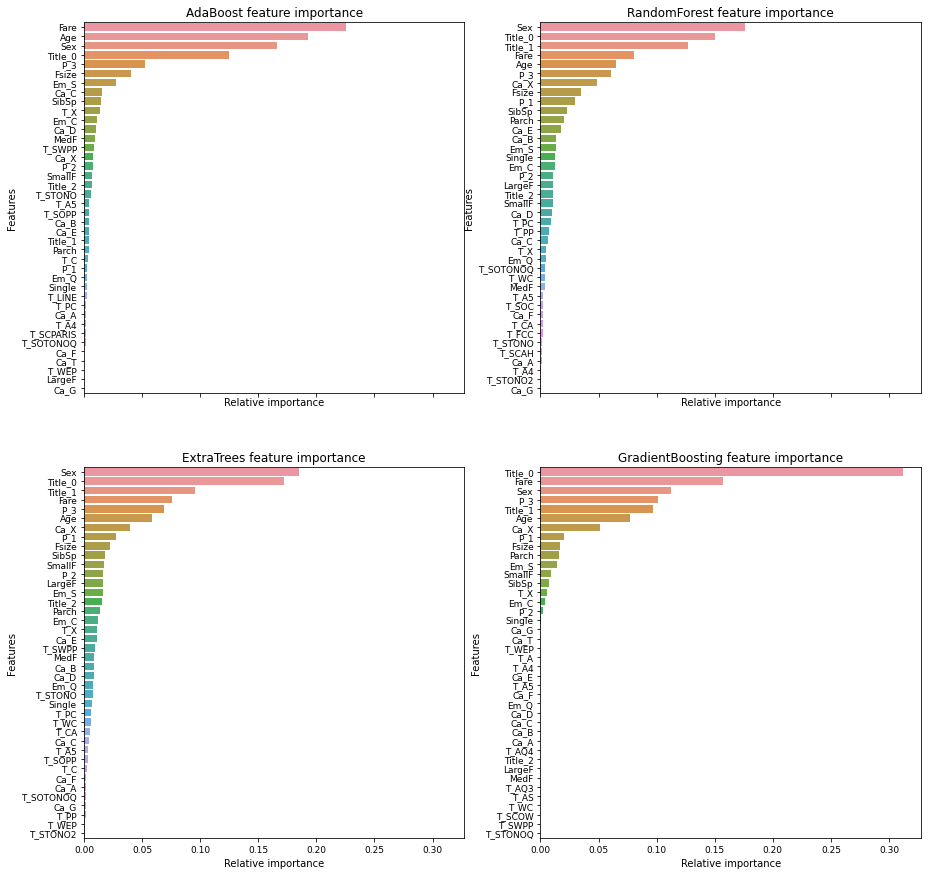

In [212]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", figsize=(15, 15))

classifiers = [("AdaBoost", ada_best), ("RandomForest", rf_best),
               ("ExtraTrees", ex_best), ("GradientBoosting", gbc_best)]

for i in range(nrows):
    for j in range(ncols):
        name, est = classifiers[i*nrows + j]
        indices = np.argsort(est.feature_importances_)[::-1][:40]
        g = sns.barplot(x=est.feature_importances_[indices], y=X.columns[indices], orient="h", ax=axes[i][j])
        g.set_ylabel("Features")
        g.set_xlabel("Relative importance")
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")

So we see that Sex, Age, Title and Fare are the most important features.

Let's see if the predictions of the different predictors can be correllated.

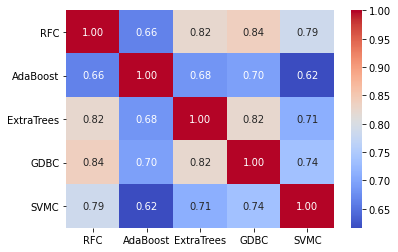

In [215]:
test_survived_rfc = pd.Series(rf_best.predict(test), name="RFC")
test_survived_ada = pd.Series(ada_best.predict(test), name="AdaBoost")
test_survived_ex = pd.Series(ex_best.predict(test), name="ExtraTrees")
test_survived_gdbc = pd.Series(gbc_best.predict(test), name="GDBC")
test_survived_svmc = pd.Series(svmc_best.predict(test), name="SVMC")

ensemble_results = pd.concat([test_survived_rfc, test_survived_ada, test_survived_ex,
                              test_survived_gdbc, test_survived_svmc], axis=1)

sns.heatmap(ensemble_results.corr(), annot=True, fmt=".2f", cmap="coolwarm")

So most seem to have similar results except when compared with ADABoost.

This warrants an ensemble vote.

## Ensembling

Let's use a voting classifier to combine the predictions coming from the 5 classifiers. Use `voting="soft"` to take into account the probability of each vote.

In [227]:
votingC = VotingClassifier(estimators=[('rfc', rf_best), ('ext', ex_best),
                                      ('gbc', gbc_best), ('svmc', svmc_best)])

votingC = votingC.fit(X, y)

## Prediction

In [228]:
testSurvived = pd.Series(votingC.predict(test), name="Survived")

res = pd.read_csv(test_data)

res["Survived"] = testSurvived

res[["PassengerId", "Survived"]].to_csv("submission.csv", index=False)